In [16]:
"""
This notebook is the lower bound that we need to beat for DINO.
"""

'\nThis notebook is the lower bound that we need to beat for DINO.\n'

In [17]:
import json
import os
import sys
import numpy as np
sys.path.append(os.path.abspath("../../.."))   # one level up from notebook/
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from data.utils.dataloaders import ReconstructionDataset_Heuristic
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, Dataset



In [18]:
# read json file 
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json', 'r') as f:
    reconst_losses = json.load(f)

In [19]:
losses = defaultdict(lambda: {"lpips": [], "dino": []})

for item in reconst_losses:
    k = item["k_value"]
    losses[k]["dino"].append(item["DINOv2FeatureLoss"])


In [20]:
all_dino  = [v for k in losses for v in losses[k]["dino"]]

min_loss_DINO  = min(all_dino)
max_loss_DINO  = max(all_dino)
print("DINOV2Feature Loss range:", min_loss_DINO, "to", max_loss_DINO)


DINOV2Feature Loss range: 0.010271608829498291 to 1.1576836109161377


In [21]:
print("\nDINOV2 Feature Loss statistics per token count:")
for k in sorted(losses):
    dino_vals = np.array(losses[k]["dino"])
    print(f"k={k}: mean={dino_vals.mean():.3f}, std={dino_vals.std():.3f}")



DINOV2 Feature Loss statistics per token count:
k=1: mean=0.602, std=0.270
k=2: mean=0.524, std=0.256
k=4: mean=0.470, std=0.250
k=8: mean=0.379, std=0.220
k=16: mean=0.331, std=0.198
k=32: mean=0.286, std=0.178
k=64: mean=0.255, std=0.164
k=128: mean=0.227, std=0.149
k=256: mean=0.191, std=0.128


In [22]:
# read dino distances:
with open("/BS/data_mani_compress/work/thesis/thesis/data/datasets/dino_distances/val_categorized/dino_nearest_centroid_distances_cosine.json") as f:
    dino_distances = json.load(f)

In [23]:
print(dino_distances["images"][0]["dino_distance"])  # print keys of the first entry

0.4796658754348755


In [24]:
dino_distance_used = [dino_distances["images"][i]["dino_distance"] for i in range(len(dino_distances["images"]))]
print(len(dino_distance_used))

50000


In [25]:
ds = ReconstructionDataset_Heuristic(
    reconstruction_data=reconst_losses,  # or your processed list of dicts
    dino_dist_information=dino_distance_used,
    error_key=["DINOv2FeatureLoss"],
)

In [26]:
k_values = [1,2,4,8,16,32,64,128,256]
heuristic_dino_results = {}
for k in k_values:
    dino_dist = []
    y = []
    for dp in ds:
        if dp["k_value"] == k:
            y.append(dp["DINOv2FeatureLoss"])
            dino_dist.append(dp["dino_dist"])
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.array(dino_dist).reshape(-1, 1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_dino_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.1902, R²=0.299
k=2: Heuristic method  MAE=0.1762, R²=0.303
k=4: Heuristic method  MAE=0.1656, R²=0.322
k=8: Heuristic method  MAE=0.1290, R²=0.398
k=16: Heuristic method  MAE=0.1147, R²=0.389
k=32: Heuristic method  MAE=0.1024, R²=0.373
k=64: Heuristic method  MAE=0.0954, R²=0.349
k=128: Heuristic method  MAE=0.0885, R²=0.314
k=256: Heuristic method  MAE=0.0781, R²=0.270


In [27]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

baseline_results = {}
for k in k_values:
    y = []

    for dp in ds:
        if dp["k_value"] == k:
            y.append(dp["DINOv2FeatureLoss"])
    
    if len(y) < 5:
        continue

    y = np.array(y)

    # -------------------------
    # Baseline: predict mean(y)
    # -------------------------
    y_base = np.full_like(y, y.mean())
    mae_base  = mean_absolute_error(y, y_base)
    baseline_results[k] = mae_base

    print(f"k={k}: Baseline MAE: {mae_base:.4f}")


k=1: Baseline MAE: 0.2371
k=2: Baseline MAE: 0.2238
k=4: Baseline MAE: 0.2175
k=8: Baseline MAE: 0.1862
k=16: Baseline MAE: 0.1645
k=32: Baseline MAE: 0.1439
k=64: Baseline MAE: 0.1308
k=128: Baseline MAE: 0.1169
k=256: Baseline MAE: 0.0985


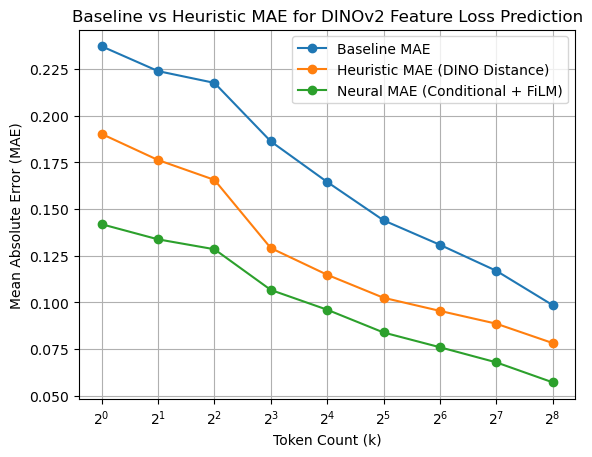

In [30]:
# plot baseline vs heuristic
ks = sorted(baseline_results.keys())
baseline_maes = [baseline_results[k] for k in ks]
heuristic_maes = [heuristic_dino_results[k] for k in ks]
neural_film_maes = [0.1418, 0.1337, 0.1284, 0.1066, 0.0960, 0.0838, 0.0759, 0.0678, 0.0571]
plt.plot(ks, baseline_maes, marker='o', label='Baseline MAE')
plt.plot(ks, heuristic_maes, marker='o', label='Heuristic MAE (DINO Distance)')
plt.plot(ks, neural_film_maes, marker='o', label='Neural MAE (Conditional + FiLM)')
plt.xscale('log', base=2)
plt.xlabel('Token Count (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Baseline vs Heuristic MAE for DINOv2 Feature Loss Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# percentage wise improvements over baseline
print("Percentage improvements over baseline:")
for k in k_values:
    if k in baseline_results and k in baseline_results:
        baseline_mae = baseline_results[k]
        heuristic_mae = heuristic_dino_results[k]
        improvement = (baseline_mae - heuristic_mae) / baseline_mae * 100
        print(f"k={k}: Improvement = {improvement:.2f}%")

Percentage improvements over baseline:
k=1: Improvement = 19.80%
k=2: Improvement = 21.29%
k=4: Improvement = 23.89%
k=8: Improvement = 30.70%
k=16: Improvement = 30.24%
k=32: Improvement = 28.84%
k=64: Improvement = 27.08%
k=128: Improvement = 24.26%
k=256: Improvement = 20.64%
